# DESIGNTK530_I-7 | Coston, Kimberly

In [ ]:
# THIS IS AN UPDATE FOR ASSIGNMENT I-8 again
! pip install gdown
import gdown
files = {
    "df_rrtevents_pivoted.csv": "12ooi8Ayk2VMZeLnDbVZWiq5GXt0C10_-",
    "df_codes_pivoted.csv": "1gzOxZaTxgIy7IKU3ULhrOHbC4fSUhKDW",
    "df_rrtconsults_pivoted.csv": "1iScHZkprg6lge0GSQrD-6HiaqLgv4gHq"
}

for name, fid in files.items():
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url, name, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=12ooi8Ayk2VMZeLnDbVZWiq5GXt0C10_-
To: /content/df_rrtevents_pivoted.csv
100%|██████████| 718k/718k [00:00<00:00, 22.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gzOxZaTxgIy7IKU3ULhrOHbC4fSUhKDW
To: /content/df_codes_pivoted.csv
100%|██████████| 32.6k/32.6k [00:00<00:00, 42.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iScHZkprg6lge0GSQrD-6HiaqLgv4gHq
To: /content/df_rrtconsults_pivoted.csv
100%|██████████| 2.24M/2.24M [00:00<00:00, 62.7MB/s]


# **1. Find a topic & a dataset**

## Problem 1.1

This dataset contains hospital Rapid Response Team (RRT) and escalation event records across multiple inpatient units. It includes quantitative data such as patient age and event duration, as well as qualitative text fields including hospital department and the documented reason for activation. Event types include RRT Consults (early clinical concern), RRT activations, and Code Blue emergency events — enabling comparison between proactive vs. reactive escalation cultures across different units.

The goal is to explore whether hospital units demonstrate distinct escalation behavior patterns (proxied by their relative use of early RRT consults versus later full RRT or Code Blue activations) and whether earlier escalation is associated with better measurable outcomes such as lower ICU transfer rates.

Note: For privacy compliance, I am submitting synthetic, de-identified mock data that mirrors the values and structure of the actual datasets used in this analysis. No Protected Health Information (PHI) is included.

# **2. Clean, Organize, & Explore**

## Problem 2.1

## Helper Functions

This cell contains all reusable functions used throughout the analysis.


In [2]:
# I used an LLM to clean up my code after everything and it said my code was very repetitive so it made this cell of reusable functions to decrease the repetition. The LLM made this entire cell.
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter, defaultdict
from itertools import combinations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power

# ==================== DATA LOADING & CLEANING ====================

def load_and_prepare_datasets(files_dict):
    """
    Load multiple CSV files and add Event Type column.

    Args:
        files_dict: Dictionary with {filename: event_type}

    Returns:
        List of prepared dataframes
    """
    dataframes = []
    for filename, event_type in files_dict.items():
        df = pd.read_csv(filename)
        df['Event Type'] = event_type
        # Move Event Type to first column
        cols = ['Event Type'] + [col for col in df.columns if col != 'Event Type']
        df = df[cols]
        dataframes.append(df)
    return dataframes

def calculate_event_duration(df, date_col='Event Start Date', start_col='RRT Start Time', end_col='RRT End Time'):
    """
    Calculate event duration handling midnight crossover.

    Returns:
        DataFrame with Event Duration column added (in minutes)
    """
    # Combine date and time strings
    date_str = df[date_col].astype(str)
    start_time_str = df[start_col].astype(str)
    end_time_str = df[end_col].astype(str)

    # Create datetime objects
    start_datetime = pd.to_datetime(date_str + ' ' + start_time_str, errors='coerce')
    end_datetime = pd.to_datetime(date_str + ' ' + end_time_str, errors='coerce')

    # Handle midnight crossover
    valid_mask = start_datetime.notna() & end_datetime.notna()
    crossed_midnight = (end_datetime < start_datetime) & valid_mask
    end_datetime.loc[crossed_midnight] = end_datetime.loc[crossed_midnight] + pd.Timedelta(days=1)

    # Calculate duration in minutes
    df['Event Duration'] = (end_datetime - start_datetime).dt.total_seconds() / 60
    df['Event Duration'] = df['Event Duration'].round(0).astype('Int64')

    return df

def clean_combined_dataset(df):
    """
    Apply standard cleaning operations to combined dataset.
    """
    # Drop unnamed columns
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Convert date column
    df['Event Start Date'] = pd.to_datetime(df['Event Start Date'], errors='coerce')

    # Convert time columns
    df['RRT Start Time'] = pd.to_datetime(df['RRT Start Time'], format='%H:%M:%S', errors='coerce').dt.time
    df['RRT End Time'] = pd.to_datetime(df['RRT End Time'], format='%H:%M:%S', errors='coerce').dt.time

    # Convert Age to integer
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce').astype('Int64')

    # Handle event-type-specific missing values
    df.loc[df['Event Type'] != 'RRT Consult', 'RRT Consult Trigger'] = 'N/A'
    df['RRT Consult Trigger'] = df['RRT Consult Trigger'].fillna('Not specified')

    df.loc[df['Event Type'] != 'Code Blue', 'Location of Code'] = 'N/A'
    df['Location of Code'] = df['Location of Code'].fillna('Unknown')

    df.loc[df['Event Type'] == 'Code Blue', 'RRT Reason For Call'] = 'N/A'
    df['RRT Reason For Call'] = df['RRT Reason For Call'].fillna('Not specified')

    # Fill intervention columns
    intervention_cols = [
        'RRT Interventions',
        'RRT Lab Interventions',
        'RRT Pre Respiratory Interventions',
        'RRT Procedure Interventions',
        'RRT Respiratory Interventions'
    ]
    for col in intervention_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None')

    # Fill other missing values
    df['Department after RRT'] = df['Department after RRT'].astype(str).replace('nan', np.nan).fillna('Unknown')
    df['Outcome'] = df['Outcome'].fillna('Unknown')

    # Drop rows with missing times
    df = df.dropna(subset=['RRT Start Time', 'RRT End Time'])

    return df

def create_age_groups(df, age_col='Age'):
    """Create age group categories."""
    df['Age Group'] = pd.cut(df[age_col],
                              bins=[0, 18, 30, 40, 50, 60, 70, 80, 90, 120],
                              labels=['0-18', '19-30', '31-40', '41-50', '51-60',
                                      '61-70', '71-80', '81-90', '90+'])
    return df

def create_duration_categories(df, duration_col='Event Duration'):
    """Create duration categories."""
    df_valid = df[df[duration_col].notna()].copy()
    df_valid['Duration Category'] = pd.cut(
        df_valid[duration_col],
        bins=[0, 15, 30, 45, 60, 90, 120, 180, float('inf')],
        labels=['0-15 min', '16-30 min', '31-45 min', '46-60 min',
                '61-90 min', '91-120 min', '121-180 min', '180+ min']
    )
    return df_valid

# ==================== DEPARTMENT FILTERING ====================

def filter_departments(df, event_types=['RRT', 'RRT Consult'],
                       min_events=25,
                       exclude_icus=True,
                       exclude_list=None):
    """
    Filter departments based on event count and type.

    Args:
        df: DataFrame with event data
        event_types: List of event types to include
        min_events: Minimum number of events required
        exclude_icus: Whether to exclude ICU units
        exclude_list: List of specific departments to exclude

    Returns:
        List of department names meeting criteria
    """
    if exclude_list is None:
        exclude_list = []

    # Count events by department
    dept_counts = df[df['Event Type'].isin(event_types)].groupby('Slices by Department').size()

    # Filter by minimum events
    valid_depts = dept_counts[dept_counts >= min_events].index.tolist()

    # Exclude ICUs if requested
    if exclude_icus:
        valid_depts = [dept for dept in valid_depts
                       if 'ICU' not in dept.upper() and 'MICU' not in dept.upper()]

    # Exclude specific departments
    valid_depts = [dept for dept in valid_depts if dept not in exclude_list]

    return valid_depts

def get_top_bottom_departments(df, n=5, event_types=['RRT', 'RRT Consult'],
                                min_events=25, exclude_icus=True, exclude_list=None):
    """
    Get top N and bottom N departments by event count.

    Returns:
        tuple: (top_depts, bottom_depts)
    """
    valid_depts = filter_departments(df, event_types, min_events, exclude_icus, exclude_list)
    dept_counts = df[df['Event Type'].isin(event_types)].groupby('Slices by Department').size()
    dept_counts_filtered = dept_counts[valid_depts]

    top_depts = dept_counts_filtered.nlargest(n).index.tolist()
    bottom_depts = dept_counts_filtered.nsmallest(n).index.tolist()

    return top_depts, bottom_depts

# ==================== DEPARTMENT METRICS ====================

def calculate_department_metrics(df, departments, favorable_outcomes=['Stayed in room']):
    """
    Calculate consult ratio and favorable outcome percentage for departments.

    Returns:
        DataFrame with department metrics
    """
    dept_stats = []

    for dept in departments:
        dept_df = df[df['Slices by Department'] == dept]

        # Consult Ratio
        consult_count = dept_df[dept_df['Event Type'] == 'RRT Consult'].shape[0]
        rrt_count = dept_df[dept_df['Event Type'] == 'RRT'].shape[0]
        total_escalations = consult_count + rrt_count
        consult_ratio = consult_count / total_escalations if total_escalations > 0 else 0

        # Favorable Outcome %
        favorable_count = dept_df[dept_df['Outcome'].isin(favorable_outcomes)].shape[0]
        total_events = dept_df.shape[0]
        favorable_pct = (favorable_count / total_events * 100) if total_events > 0 else 0

        dept_stats.append({
            'Slices by Department': dept,
            'Consult Ratio': consult_ratio,
            'Favorable Outcome %': favorable_pct,
            'Total Events': total_events,
            'Consult Count': consult_count,
            'RRT Count': rrt_count
        })

    return pd.DataFrame(dept_stats)

# ==================== INTERVENTION ANALYSIS ====================

def parse_interventions(df, intervention_col='RRT Interventions',
                        exclude_values=['None', 'N/A', 'Not specified', 'Unknown']):
    """
    Parse intervention strings into individual items.

    Returns:
        Counter object with intervention frequencies
    """
    interventions_raw = df[~df[intervention_col].isin(exclude_values)][intervention_col]

    all_interventions = []
    for intervention_string in interventions_raw:
        if pd.notna(intervention_string):
            items = [item.strip() for item in str(intervention_string).split(',')]
            all_interventions.extend(items)

    return Counter(all_interventions), interventions_raw

def calculate_intervention_cooccurrence(df, intervention_col='RRT Interventions',
                                       exclude_values=['None', 'N/A', 'Not specified', 'Unknown']):
    """
    Calculate co-occurrence of interventions.

    Returns:
        List of ((intervention1, intervention2), count) tuples sorted by frequency
    """
    interventions_raw = df[~df[intervention_col].isin(exclude_values)][intervention_col]

    co_occurrence = defaultdict(int)

    for intervention_string in interventions_raw:
        if pd.notna(intervention_string):
            items = [item.strip() for item in str(intervention_string).split(',')]
            items = sorted(set(items))

            for pair in combinations(items, 2):
                co_occurrence[pair] += 1

    return sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

def analyze_department_interventions(df, departments, intervention_col='RRT Interventions'):
    """
    Analyze interventions for a group of departments.

    Returns:
        Dictionary with intervention analysis results
    """
    dept_df = df[df['Slices by Department'].isin(departments)]
    intervention_freq, interventions_raw = parse_interventions(dept_df, intervention_col)
    co_occurrence = calculate_intervention_cooccurrence(dept_df, intervention_col)

    all_interventions = sum(intervention_freq.values())

    return {
        'intervention_freq': intervention_freq,
        'co_occurrence': co_occurrence,
        'total_interventions': all_interventions,
        'total_events': len(interventions_raw),
        'avg_per_event': all_interventions / len(interventions_raw) if len(interventions_raw) > 0 else 0,
        'unique_types': len(intervention_freq)
    }

# ==================== REASON CATEGORIZATION ====================

def categorize_rrt_reason(reason):
    """Categorize RRT call reasons into clinical categories."""
    if pd.isna(reason) or reason in ['N/A', 'Not specified', 'Unknown']:
        return 'Unknown'

    reason_str = str(reason).strip()

    clinical_emergency = [
        'Unresponsive', 'Staff concerned', 'Respiratory distress', 'Chest pain', 'Seizures',
        'Hypotension', 'Bradycardia', 'Dysrhythmia', 'Sepsis',
        'O2 sat < 90', 'Pulmonary edema', 'Bleeding', 'Syncopal episode',
        'Hypothermia', 'Hypoglycemia', 'increase in O2 requirements',
        'Tachycardia', 'Hypertension', 'Fever', 'AMS', 'Alcohol withdrawal'
    ]

    procedural_non_urgent = [
        'IV access/insertion', 'Lab specimen collection',
        'Device/Medication Troubleshooting', 'Post RRT Rounding'
    ]

    assessment_monitoring = [
        'Nursing Assessment/Reassessment',
        'Lab result/abnormality', 'Other', 'Other***'
    ]

    if any(cat in reason_str for cat in clinical_emergency):
        return 'Clinical Emergency'
    elif any(cat in reason_str for cat in procedural_non_urgent):
        return 'Procedural/Non-urgent'
    elif any(cat in reason_str for cat in assessment_monitoring):
        return 'Assessment/Monitoring'
    else:
        return 'Unknown'

# ==================== VISUALIZATION HELPERS ====================

def create_horizontal_bar_chart(data, x_col, y_col, title, color_scale='Viridis',
                                 height=800, width=1100, save_path=None):
    """Create a horizontal bar chart with Plotly."""
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=data[x_col],
        y=data[y_col],
        orientation='h',
        marker=dict(
            color=data[x_col],
            colorscale=color_scale,
            showscale=True,
            colorbar=dict(title="Frequency")
        ),
        text=data[x_col],
        textposition='outside',
        hovertemplate='<b>%{y}</b><br>Count: %{x}<extra></extra>'
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Count',
        yaxis_title='',
        height=height,
        width=width,
        yaxis={'categoryorder': 'total ascending'}
    )

    if save_path:
        fig.write_html(save_path)

    return fig

def create_stacked_bar_chart(data, x_col, y_cols, title, colors=None,
                             height=600, width=1200, save_path=None):
    """Create a stacked bar chart with Plotly."""
    fig = go.Figure()

    if colors is None:
        colors = {}

    for y_col in y_cols:
        if y_col in data.columns:
            fig.add_trace(go.Bar(
                name=y_col,
                x=data.index,
                y=data[y_col],
                marker_color=colors.get(y_col, None),
                text=data[y_col],
                textposition='inside',
                textfont=dict(color='white', size=10)
            ))

    fig.update_layout(
        title=title,
        barmode='stack',
        height=height,
        width=width,
        showlegend=True
    )

    fig.update_xaxes(tickangle=45)

    if save_path:
        fig.write_html(save_path)

    return fig

def create_wordcloud(freq_dict, title, colormap='viridis',
                     save_path=None, figsize=(20, 10)):
    """Create a word cloud from frequency dictionary."""
    wordcloud = WordCloud(
        width=1600, height=800,
        background_color='white',
        colormap=colormap,
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return wordcloud

def create_scatter_with_quadrants(data, x_col, y_col, size_col, title,
                                  color_col=None, save_path=None):
    """Create scatter plot with median quadrant lines."""
    median_x = data[x_col].median()
    median_y = data[y_col].median()

    fig = px.scatter(
        data,
        x=x_col,
        y=y_col,
        size=size_col,
        color=color_col if color_col else y_col,
        hover_name=data.index if isinstance(data.index, pd.Index) else None,
        color_continuous_scale='RdYlGn',
        title=title
    )

    # Add median lines
    fig.add_vline(x=median_x, line_dash="dash", line_color="gray")
    fig.add_hline(y=median_y, line_dash="dash", line_color="gray")

    fig.update_layout(height=700, width=1200)

    if save_path:
        fig.write_html(save_path)

    return fig

Some final cleaning edits are made on this notebook. However, the majority of the data cleaning can be found in [this separate notebook](https://.research.google.com/drive/1_SCrjt1NvJqjq2OrHyEwinmiTdJB-S2o?=usp=sharing).

`https://colab.research.google.com/drive/1_SCrjt1NvJqjq2OrHyEwinmiTdJB-S2o?=usp=sharing`

In [3]:
# Load and prepare datasets using helper function
files_dict = {
    'df_codes_pivoted.csv': 'Code Blue',
    'df_rrtconsults_pivoted.csv': 'RRT Consult',
    'df_rrtevents_pivoted.csv': 'RRT'
}

df_codes_pivoted, df_rrtconsults_pivoted, df_rrtevents_pivoted = load_and_prepare_datasets(files_dict)

In [4]:
# Combine the datasets
combined_df = pd.concat([df_rrtevents_pivoted, df_codes_pivoted, df_rrtconsults_pivoted], ignore_index=True)
combined_df.to_csv('combined_df.csv', index=False)

In [5]:
# Load and clean the combined dataset
df = pd.read_csv('combined_df.csv')

# Rename SDE DateTime before cleaning
if 'SDE DateTime' in df.columns:
    df = df.rename(columns={'SDE DateTime': 'Event Start Date'})

# Apply standard cleaning with helper function
df = clean_combined_dataset(df)

# ## Data Validation & Quality Checks
print("DATASET SUMMARY")

print(f"\nDataset Size:")
print(f"   Total rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")

print(f"\nDate Range:")
print(f"   From: {df['Event Start Date'].min()}")
print(f"   To: {df['Event Start Date'].max()}")

print(f"\n Event Type Distribution:")
for event_type, count in df['Event Type'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"   {event_type}: {count:,} ({pct:.2f}%)")

print(f"\nOutcome Distribution (Top 10):")
for outcome, count in df['Outcome'].value_counts().head(10).items():
    pct = (count / len(df)) * 100
    print(f"   {outcome}: {count:,} ({pct:.2f}%)")

/tmp/ipython-input-3015688772.py:69: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Event Start Date'] = pd.to_datetime(df['Event Start Date'], errors='coerce')


DATASET SUMMARY

Dataset Size:
   Total rows: 14,873
   Total columns: 16

Date Range:
   From: 2024-07-01 03:13:00
   To: 2025-06-30 23:51:00

 Event Type Distribution:
   RRT Consult: 11,711 (78.74%)
   RRT: 2,890 (19.43%)
   Code Blue: 272 (1.83%)

Outcome Distribution (Top 10):
   Stayed in room: 12,731 (85.60%)
   Transferred to ICU: 1,150 (7.73%)
   RRT: 251 (1.69%)
   CCSN: 238 (1.60%)
   Survived with ROSC: 186 (1.25%)
   Stroke code: 89 (0.60%)
   Efforts terminated no ROSC: 83 (0.56%)
   Other: 37 (0.25%)
   Changed to SD status: 28 (0.19%)
   Transferred to ED: 21 (0.14%)


## Problem 2.2

Quantitative continuous - descriptive statistics

In [7]:
# Save the completely cleaned data
df.to_csv('combined_df_cleaned.csv', index=False)

In [43]:
# Reload the data fresh to avoid any issues from previous runs
df = pd.read_csv("combined_df_cleaned.csv")

def calculate_event_duration(df, date_col='Event Start Date', start_col='RRT Start Time', end_col='RRT End Time'):
    """
    Calculate event duration in minutes, handling times that span midnight.
    """
    # Ensure date column is datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Extract time from start column (which contains datetime)
    df['_start_time'] = pd.to_datetime(df[start_col], errors='coerce').dt.time

    # Parse end time (which is already just time)
    df['_end_time'] = pd.to_datetime(df[end_col], format='%H:%M:%S', errors='coerce').dt.time

    # Combine actual event date with the extracted times
    df['_start_datetime'] = pd.to_datetime(
        df[date_col].dt.date.astype(str) + ' ' + df['_start_time'].astype(str),
        errors='coerce'
    )

    df['_end_datetime'] = pd.to_datetime(
        df[date_col].dt.date.astype(str) + ' ' + df['_end_time'].astype(str),
        errors='coerce'
    )

    # Handle cases where end time is before start time (crosses midnight)
    mask = df['_end_datetime'] < df['_start_datetime']
    df.loc[mask, '_end_datetime'] = df.loc[mask, '_end_datetime'] + pd.Timedelta(days=1)

    # Calculate duration in minutes
    df['Event Duration'] = (df['_end_datetime'] - df['_start_datetime']).dt.total_seconds() / 60

    # Convert to Int64 to handle NaN values properly
    df['Event Duration'] = df['Event Duration'].astype('Int64')

    # Drop temporary columns
    df.drop(['_start_time', '_end_time', '_start_datetime', '_end_datetime'], axis=1, inplace=True)

    return df


# Calculate Event Duration
df = calculate_event_duration(df, date_col='Event Start Date', start_col='RRT Start Time', end_col='RRT End Time')

print(f"\nEvent Duration Stats")
print(f"Non-null count: {df['Event Duration'].notna().sum()}")
print(f"Null count: {df['Event Duration'].isna().sum()}")
print(f"Mean: {df['Event Duration'].mean():.2f} minutes")
print(f"Median: {df['Event Duration'].median():.2f} minutes")
print(f"Std Dev: {df['Event Duration'].std():.2f} minutes")
print(f"Min: {df['Event Duration'].min():.2f} minutes")
print(f"Max: {df['Event Duration'].max():.2f} minutes")

/tmp/ipython-input-1165438171.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.




Event Duration Stats
Non-null count: 14873
Null count: 0
Mean: 32.01 minutes
Median: 17.00 minutes
Std Dev: 107.51 minutes
Min: 0.00 minutes
Max: 1439.00 minutes


In [44]:
# Quantitative continuous variables
continuous_vars = ['Age']

for col in continuous_vars:
    print(f"\n--- {col} ---")
    # Check if the column exists before proceeding
    if col in df.columns:
        print(f"Mean: {df[col].mean():.2f}")
        print(f"Median: {df[col].median():.2f}")
        # Check if mode() returns an empty Series before accessing index 0
        mode_val = df[col].mode()
        if not mode_val.empty:
            print(f"Mode: {mode_val[0]:.2f}")
        else:
            print(f"Mode: No unique mode found or all values are NaN")
        print(f"Standard Deviation: {df[col].std():.2f}")
    else:
        print(f"Error: Column '{col}' not found in DataFrame.") # Added a check


--- Age ---
Mean: 61.60
Median: 65.00
Mode: 67.00
Standard Deviation: 17.48


Quantitative discrete and qualitative data - descriptive statistics

In [45]:
# The LLM generated the crosstabulations of data after it suggested I do so.
# Frequency Tables for Quantitative Discrete and Qualitative Data

df['Event Start Date'] = pd.to_datetime(df['Event Start Date'])

# Quantitative Discrete Variables

# Create Age Groups
df = create_age_groups(df)

print("\nAGE GROUPS")
age_table = pd.DataFrame({
    'Frequency': df['Age Group'].value_counts().sort_index(),
    'Percentage (%)': (df['Age Group'].value_counts(normalize=True).sort_index() * 100).round(2)
})
display(age_table)

# Create Duration Categories
duration_df = create_duration_categories(df)

print("\nEvent Duration Categories")
duration_table = pd.DataFrame({
    'Frequency': duration_df['Duration Category'].value_counts().sort_index(),
    'Percentage (%)': (duration_df['Duration Category'].value_counts(normalize=True).sort_index() * 100).round(2)
})
display(duration_table)

# Day of Week
df['Day of Week'] = df['Event Start Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("\nEvents by day of week")
dow_table = pd.DataFrame({
    'Frequency': df['Day of Week'].value_counts().reindex(day_order),
    'Percentage (%)': (df['Day of Week'].value_counts(normalize=True).reindex(day_order) * 100).round(2)
})
display(dow_table)


# Qualitative Variables

print("\nEvent Type")
event_table = pd.DataFrame({
    'Frequency': df['Event Type'].value_counts(),
    'Percentage (%)': (df['Event Type'].value_counts(normalize=True) * 100).round(2)
})
display(event_table)

print("\nOutcome")
outcome_table = pd.DataFrame({
    'Frequency': df['Outcome'].value_counts(),
    'Percentage (%)': (df['Outcome'].value_counts(normalize=True) * 100).round(2)
})
display(outcome_table)

print("\nTOP 20 Departments")
dept_table = pd.DataFrame({
    'Frequency': df['Slices by Department'].value_counts().head(20),
    'Percentage (%)': (df['Slices by Department'].value_counts(normalize=True).head(20) * 100).round(2)
})
display(dept_table)

print("\nTOP 20 RRT Reasons")
reason_df = df[~df['RRT Reason For Call'].isin(['N/A', 'Not specified'])]
reason_table = pd.DataFrame({
    'Frequency': reason_df['RRT Reason For Call'].value_counts().head(20),
    'Percentage (%)': (reason_df['RRT Reason For Call'].value_counts(normalize=True).head(20) * 100).round(2)
})
display(reason_table)

print("\nRRT Consult Trigger")
trigger_df = df[(df['Event Type'] == 'RRT Consult') & (~df['RRT Consult Trigger'].isin(['N/A', 'Not specified']))]
trigger_table = pd.DataFrame({
    'Frequency': trigger_df['RRT Consult Trigger'].value_counts(),
    'Percentage (%)': (trigger_df['RRT Consult Trigger'].value_counts(normalize=True) * 100).round(2)
})
display(trigger_table)

print("\nLocation of code blues")
code_df = df[(df['Event Type'] == 'Code Blue') & (~df['Location of Code'].isin(['Unknown', 'N/A']))]
location_table = pd.DataFrame({
    'Frequency': code_df['Location of Code'].value_counts().head(20),
    'Percentage (%)': (code_df['Location of Code'].value_counts(normalize=True).head(20) * 100).round(2)
})
display(location_table)

# Crosstabulations (Relationships Between Variables)

print("\nOUTCOME × EVENT TYPE")
outcome_event_cross = pd.crosstab(df['Event Type'], df['Outcome'], margins=True, margins_name='Total')
display(outcome_event_cross)

print("\nOUTCOME × EVENT TYPE (Percentages)")
outcome_event_pct = pd.crosstab(df['Event Type'], df['Outcome'], normalize='index') * 100
display(outcome_event_pct.round(2))

print("\nOUTCOME × DEPARTMENT AFTER RRT (Top 10 Departments)")
# Get top 10 departments after RRT
top_depts = df['Department after RRT'].value_counts().head(10).index
dept_subset = df[df['Department after RRT'].isin(top_depts)]
outcome_dept_cross = pd.crosstab(dept_subset['Department after RRT'], dept_subset['Outcome'])
display(outcome_dept_cross)

print("\nAGE GROUP × EVENT TYPE")
age_event_cross = pd.crosstab(df['Age Group'], df['Event Type'], margins=True, margins_name='Total')
display(age_event_cross)


AGE GROUPS


,Frequency,Percentage (%)
Age Group,,
0-18,135,0.91
19-30,841,5.66
31-40,1089,7.33
41-50,1414,9.51
51-60,2572,17.30
61-70,3611,24.29
71-80,3562,23.96
81-90,1430,9.62
90+,211,1.42



Event Duration Categories


,Frequency,Percentage (%)
Duration Category,,
0-15 min,7136,48.15
16-30 min,4007,27.04
31-45 min,1974,13.32
46-60 min,841,5.68
61-90 min,546,3.68
91-120 min,126,0.85
121-180 min,56,0.38
180+ min,133,0.90



Events by day of week


,Frequency,Percentage (%)
Day of Week,,
Monday,1985,13.35
Tuesday,2178,14.64
Wednesday,2137,14.37
Thursday,2232,15.01
Friday,2200,14.79
Saturday,2193,14.74
Sunday,1948,13.10



Event Type


,Frequency,Percentage (%)
Event Type,,
RRT Consult,11711,78.74
RRT,2890,19.43
Code Blue,272,1.83



Outcome


,Frequency,Percentage (%)
Outcome,,
Stayed in room,12731,85.60
Transferred to ICU,1150,7.73
RRT,251,1.69
CCSN,238,1.60
Survived with ROSC,186,1.25
Stroke code,89,0.60
Efforts terminated no ROSC,83,0.56
Other,37,0.25
Changed to SD status,28,0.19



TOP 20 Departments


,Frequency,Percentage (%)
Slices by Department,,
DCT 6A/6B SOLID ORGAN TRANSPLANT,1049,7.05
DUH N7300 CARDIOLOGY,910,6.12
DUH N2300 GENERAL MEDICINE,889,5.98
DMP 8E GENERAL MEDICINE STEPDOWN,860,5.78
DUH N7100 CARDIOLOGY,849,5.71
DMP 8W MED/PULMONARY MICU,779,5.24
ZZZDUH N9100 GENERAL MEDICINE,728,4.89
ZZZDUH N4300 GENERAL MEDICINE,721,4.85
ZZZDUH N6300 SURGICAL ONCOLOGY AND TRAUMA,548,3.68



TOP 20 RRT Reasons


,Frequency,Percentage (%)
RRT Reason For Call,,
Lab specimen collection,4096,28.09
Nursing Assessment/Reassessment,3777,25.90
Other,1065,7.30
Hypotension,661,4.53
Staff concerned,310,2.13
IV access/insertion,231,1.58
increase in O2 requirements,195,1.34
Dysrhythmia,186,1.28
Tachycardia,142,0.97



RRT Consult Trigger


,Frequency,Percentage (%)
RRT Consult Trigger,,
Consult ordered,6820,58.24
Outside Hospital Admission Rounds,3080,26.30
Post-RRT Rounding,1200,10.25
Rounding,321,2.74
Cardiac Decompensation Tool,65,0.56
"Outside Hospital Admission Rounds, Consult ordered",47,0.40
"Rounding, Consult ordered",39,0.33
"Consult ordered, Outside Hospital Admission Rounds",31,0.26
Adult deterioration model,24,0.20



Location of code blues


,Frequency,Percentage (%)
Location of Code,,
7 East,75,27.68
7 West,33,12.18
8 West,22,8.12
6 West,13,4.80
7300,9,3.32
Duke North Radiology,9,3.32
Other***,9,3.32
DCT 7 A/B,9,3.32
4300,7,2.58



OUTCOME × EVENT TYPE


Outcome,CCSN,Changed to SD status,Code blue,Efforts terminated no ROSC,Expired,Lateral transfer to SDU,Other,RRT,Stayed in room,Stroke code,Survived with ROSC,Transferred to ED,Transferred to ICU,Unknown,Total
Event Type,,,,,,,,,,,,,,,
Code Blue,0,0,0,83,0,0,0,0,0,0,186,0,0,3,272
RRT,207,23,20,0,8,11,24,2,1459,70,0,21,1036,9,2890
RRT Consult,31,5,0,0,0,7,13,249,11272,19,0,0,114,1,11711
Total,238,28,20,83,8,18,37,251,12731,89,186,21,1150,13,14873



OUTCOME × EVENT TYPE (Percentages)


Outcome,CCSN,Changed to SD status,Code blue,Efforts terminated no ROSC,Expired,Lateral transfer to SDU,Other,RRT,Stayed in room,Stroke code,Survived with ROSC,Transferred to ED,Transferred to ICU,Unknown
Event Type,,,,,,,,,,,,,,
Code Blue,0.00,0.00,0.00,30.51,0.00,0.00,0.00,0.00,0.00,0.00,68.38,0.00,0.00,1.10
RRT,7.16,0.80,0.69,0.00,0.28,0.38,0.83,0.07,50.48,2.42,0.00,0.73,35.85,0.31
RRT Consult,0.26,0.04,0.00,0.00,0.00,0.06,0.11,2.13,96.25,0.16,0.00,0.00,0.97,0.01



OUTCOME × DEPARTMENT AFTER RRT (Top 10 Departments)


Outcome,CCSN,Changed to SD status,Code blue,Efforts terminated no ROSC,Expired,Lateral transfer to SDU,Other,RRT,Stayed in room,Stroke code,Survived with ROSC,Transferred to ICU,Unknown
Department after RRT,,,,,,,,,,,,,
2300,17,1,0,4,1,0,0,12,888,7,0,1,0
4300,6,2,1,2,0,0,0,7,704,6,1,1,0
6300,6,0,1,0,1,0,0,10,589,2,0,2,1
7100,13,1,1,1,1,1,0,19,828,4,0,0,1
7300,13,0,2,4,2,2,0,12,891,4,1,2,0
8 East,13,3,1,1,1,3,1,15,679,6,0,3,0
8300,11,7,0,1,0,0,1,6,510,2,1,0,1
9100,9,1,2,1,0,0,0,5,727,1,0,2,0
9300,20,3,1,2,0,0,1,14,464,2,1,0,0



AGE GROUP × EVENT TYPE


Event Type,Code Blue,RRT,RRT Consult,Total
Age Group,,,,
0-18,0,117,18,135
19-30,15,150,676,841
31-40,17,208,864,1089
41-50,19,228,1167,1414
51-60,59,499,2014,2572
61-70,65,661,2885,3611
71-80,69,693,2800,3562
81-90,25,282,1123,1430
90+,1,47,163,211


## Problem 2.3

### Quantitative visualizations

In [12]:
# I used an LLM for the entire dept_stats part

# Load the combined dataset
df = pd.read_csv('combined_df_cleaned.csv')

# Convert date and time columns
# Convert 'Event Start Date' to datetime objects
df['Event Start Date'] = pd.to_datetime(df['Event Start Date'])

# Convert RRT Start Time to datetime and extract the hour
df['RRT Start Time'] = pd.to_datetime(df['RRT Start Time'])
df['Hour'] = df['RRT Start Time'].dt.hour

# Extract Day of Week
df['Day_of_Week'] = df['Event Start Date'].dt.dayofweek # Monday=0, Sunday=6

# Define off-hours: 7pm-7am (19:00-06:59) OR weekend (Saturday=5, Sunday=6)
df['Is_Off_Hours'] = ((df['Hour'] >= 19) | (df['Hour'] < 7) | (df['Day_of_Week'] >= 5))


# Calculate Consult Ratio by department (exclude ICUs)
# Using .apply with include_groups=False to avoid future warning
top_25_depts = df['Slices by Department'].value_counts().nlargest(25).index # Define top_25_depts
dept_stats = df[df['Slices by Department'].isin(top_25_depts)].groupby('Slices by Department').apply(
    lambda x: pd.Series({
        'Total_RRT_Events': ((x['Event Type'] == 'RRT') | (x['Event Type'] == 'RRT Consult')).sum(),
        'Consult_Count': (x['Event Type'] == 'RRT Consult').sum(),
        'Total_Events': len(x),
        'ICU_Transfers': (x['Outcome'] == 'Transferred to ICU').sum()
    }), include_groups=False # Add include_groups=False
)

dept_stats['Consult_Ratio'] = dept_stats['Consult_Count'] / dept_stats['Total_RRT_Events']
dept_stats['ICU_Transfer_Rate'] = dept_stats['ICU_Transfers'] / dept_stats['Total_Events']

# Define high vs low escalation departments
q75 = dept_stats['Consult_Ratio'].quantile(0.75)
q25 = dept_stats['Consult_Ratio'].quantile(0.25)

high_escalation_depts = dept_stats[dept_stats['Consult_Ratio'] >= q75].index
low_escalation_depts = dept_stats[dept_stats['Consult_Ratio'] <= q25].index


/tmp/ipython-input-412075578.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['RRT Start Time'] = pd.to_datetime(df['RRT Start Time'])


In [14]:
# Filter for top 25 departments (or use your existing top_25_depts)
dept_event_counts = df[df['Slices by Department'].isin(top_25_depts)].groupby(
    ['Slices by Department', 'Event Type']
).size().unstack(fill_value=0)

# Sort by total events
dept_event_counts['Total'] = dept_event_counts.sum(axis=1)
dept_event_counts = dept_event_counts.sort_values('Total', ascending=False)
dept_event_counts = dept_event_counts.drop('Total', axis=1)

# Create stacked bar chart
fig = go.Figure()

# Add each event type as a separate trace
colors = {
    'RRT': '#3498db',
    'RRT Consult': '#2ecc71',
    'Code Blue': '#e74c3c'
}

for event_type in ['RRT', 'RRT Consult', 'Code Blue']:
    if event_type in dept_event_counts.columns:
        fig.add_trace(go.Bar(
            name=event_type,
            x=dept_event_counts.index,
            y=dept_event_counts[event_type],
            marker_color=colors[event_type],
            hovertemplate='<b>%{x}</b><br>' +
                          event_type + ': %{y}<br>' +
                          '<extra></extra>'
        ))

# Add total count labels on top of each bar
totals = dept_event_counts.sum(axis=1)
for i, (dept, total) in enumerate(totals.items()):
    fig.add_annotation(
        x=dept,
        y=total + (totals.max() * 0.04),
        text=f"<b>{int(total)}</b>",
        showarrow=False,
        font=dict(size=10, color='black')
    )

fig.update_layout(
    title='Event Type Distribution by Department (Top 25)',
    xaxis_title='Department',
    yaxis_title='Number of Events',
    barmode='stack',
    height=600,
    width=1200,
    showlegend=True,
    legend=dict(
        x=0.86,
        y=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1
    )
)

fig.update_xaxes(tickangle=45)

fig.write_html('viz3_event_counts_by_department.html')
fig.show()

# Print summary statistics
print("\n=== Event Counts by Department Summary ===")
print(f"Total Departments: {len(dept_event_counts)}")
print(f"\nTotal Events by Type:")
for event_type in ['RRT', 'RRT Consult', 'Code Blue']:
    if event_type in dept_event_counts.columns:
        total = dept_event_counts[event_type].sum()
        print(f"  {event_type}: {total:,}")

print(f"\nDepartments with Most Events:")
print(totals.head(10))

print(f"\nDepartments with Most Code Blues:")
if 'Code Blue' in dept_event_counts.columns:
    print(dept_event_counts['Code Blue'].sort_values(ascending=False).head(10))


=== Event Counts by Department Summary ===
Total Departments: 25

Total Events by Type:
  RRT: 2,417
  RRT Consult: 11,003
  Code Blue: 220

Departments with Most Events:
Slices by Department
DCT 6A/6B SOLID ORGAN TRANSPLANT             1049
DUH N7300 CARDIOLOGY                          910
DUH N2300 GENERAL MEDICINE                    889
DMP 8E GENERAL MEDICINE STEPDOWN              860
DUH N7100 CARDIOLOGY                          849
DMP 8W MED/PULMONARY MICU                     779
ZZZDUH N9100 GENERAL MEDICINE                 728
ZZZDUH N4300 GENERAL MEDICINE                 721
ZZZDUH N6300 SURGICAL ONCOLOGY AND TRAUMA     548
ZZZDUH N8300 GENERAL SURGERY                  542
dtype: int64

Departments with Most Code Blues:
Slices by Department
DMP 7E CARDIAC INTENSIVE CARE UNIT                      65
DMP 8W MED/PULMONARY MICU                               43
DMP 6W TRAUMA SICU                                      22
DUH N7300 CARDIOLOGY                                    17
DU

In [15]:
# Calculate outcomes by department - RRT ONLY with grouped outcomes
dept_rrt_only_data = []

# Define outcome groups (same as consult version)
escalated_outcomes = ['CCSN', 'Code blue', 'Transferred to ICU', 'Stroke code', 'Expired']
non_escalated_outcomes = ['Stayed in room', 'Changed to SD status', 'Lateral transfer to SDU', 'Other']

rrt_event_counts = df[df['Event Type'] == 'RRT']['Slices by Department'].value_counts()
top_rrt_depts = rrt_event_counts.head(25).index.tolist() # Use top 20 RRT departments

# Define the list of departments to exclude
exclude_depts = [
    'DMP 7E CARDIAC INTENSIVE CARE UNIT',
    'DCT 7A/7B NEUROSCIENCE ICU',
    'DMP 8W MED/PULMONARY MICU',
    'DMP 6W TRAUMA SICU'
]

# Filter out the excluded departments and keep the top 15 remaining
filtered_depts = [d for d in top_rrt_depts if d not in exclude_depts]


for dept in filtered_depts: # Iterate over filtered RRT departments
    dept_df = df[(df['Slices by Department'] == dept) &
                 (df['Event Type'] == 'RRT')]

    if len(dept_df) > 0:
        non_escalated = dept_df['Outcome'].isin(non_escalated_outcomes).sum()
        escalated = dept_df['Outcome'].isin(escalated_outcomes).sum()
        pct_non_escalated = (non_escalated / len(dept_df) * 100)

        dept_rrt_only_data.append({
            'Department': dept,
            'Did Not Escalate': non_escalated,
            'Escalated Further': escalated,
            'Non-Escalated %': pct_non_escalated,
            'Total RRT Events': len(dept_df)
        })

rrt_only_df = pd.DataFrame(dept_rrt_only_data)
rrt_only_df = rrt_only_df.sort_values('Non-Escalated %', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Did Not Escalate<br>(Stayed in Room, SDU, Lateral, etc.)',
    x=rrt_only_df['Department'],
    y=rrt_only_df['Did Not Escalate'],
    marker_color='#28a745',
    textfont=dict(color='white', size=10),
    hovertemplate='<b>%{x}</b><br>' +
                  'Did Not Escalate: %{y}<br>' +
                  'Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=rrt_only_df['Non-Escalated %']
))

fig.add_trace(go.Bar(
    name='Escalated Further<br>(ICU, Code Blue, Expired, etc.)',
    x=rrt_only_df['Department'],
    y=rrt_only_df['Escalated Further'],
    marker_color='#dc3545',
    textfont=dict(color='white', size=10),
    hovertemplate='<b>%{x}</b><br>' +
                  'Escalated Further: %{y}<br>' +
                  'Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=100 - rrt_only_df['Non-Escalated %']
))

fig.update_layout(
    title='RRT Outcomes by Department',

    xaxis_title='Department',
    yaxis_title='Number of RRT Events',
    barmode='stack',
    height=700, # Increased height slightly
    margin=dict(t=100, b=150), # Adjusted margins
    showlegend=True,
    legend=dict(x=1.02, y=1.0, bgcolor='rgba(255,255,255,0.8)', bordercolor='black', borderwidth=1, orientation='v')
)

fig.update_xaxes(tickangle=45, automargin=True) # Added automargin
fig.update_yaxes(automargin=True) # Added automargin

fig.write_html('viz_rrt_only_outcomes_by_dept.html')
fig.show()

In [16]:
# Create horizontal bar chart for ALL interventions

# Calculate the total number of individual interventions
if 'intervention_freq' in locals():
    all_interventions = sum(intervention_freq.values())
else:
    intervention_freq, interventions_raw = parse_interventions(df, intervention_col='RRT Interventions')
    all_interventions = sum(intervention_freq.values())


top_interventions = intervention_freq.most_common(25)  # Top 25
interventions_list, counts_list = zip(*top_interventions)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(counts_list),
    y=list(interventions_list),
    orientation='h',
    marker=dict(
        color=list(counts_list),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Frequency")
    ),
    text=list(counts_list),
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Count: %{x}<br>% of all interventions: %{customdata[0]:.1f}%<br>% of events: %{customdata[1]:.1f}%<extra></extra>',
    customdata=[[c/all_interventions*100, c/len(interventions_raw)*100] for c in counts_list]
))

fig.update_layout(
    title='Top 25 Most Common RRT Interventions<br><sub>Frequency of specific clinical actions during RRT events</sub>',
    xaxis_title='Frequency (Number of Times Used)',
    yaxis_title='Intervention Type',
    height=800,
    width=1100,
    yaxis={'categoryorder': 'total ascending'}
)

fig.write_html('viz_intervention_frequency.html')
fig.show()

In [ ]:
# @title
# This cell is extra, not to be included in final grading but still want to keep it for later...
# Categorize RRT reasons using helper function
df['Reason Category'] = df['RRT Reason For Call'].apply(categorize_rrt_reason)

# Filter out Unknown from the department analysis
reason_by_dept = df[(df['Slices by Department'].isin(top_25_depts)) &
                    (df['Reason Category'] != 'Unknown')].groupby(
    ['Slices by Department', 'Reason Category']
).size().unstack(fill_value=0)

# Calculate percentages
reason_by_dept_pct = reason_by_dept.div(reason_by_dept.sum(axis=1), axis=0) * 100

# Show distribution of categories
print("Reason Category Distribution:")
print(df['Reason Category'].value_counts())
print("\nPercentages:")
print(df['Reason Category'].value_counts(normalize=True) * 100)

# Calculate by department
reason_by_dept = df[df['Slices by Department'].isin(top_25_depts)].groupby(
    ['Slices by Department', 'Reason Category']
).size().unstack(fill_value=0)

# Sort by procedural/non-urgent percentage (highest = potential inappropriate escalation)
if 'Procedural/Non-urgent' in reason_by_dept_pct.columns:
    reason_by_dept_pct = reason_by_dept_pct.sort_values('Procedural/Non-urgent', ascending=False)
else:
    reason_by_dept_pct = reason_by_dept_pct.sort_values('Assessment/Monitoring', ascending=False)

fig = go.Figure()

colors = {
    'Clinical Emergency': '#e74c3c',
    'Assessment/Monitoring': '#f39c12',
    'Procedural/Non-urgent': '#95a5a6',
    'Unknown': '#bdc3c7'
}

for category in ['Clinical Emergency', 'Assessment/Monitoring', 'Procedural/Non-urgent', 'Unknown']:
    if category in reason_by_dept_pct.columns:
        fig.add_trace(go.Bar(
            name=category,
            x=reason_by_dept_pct.index,
            y=reason_by_dept_pct[category],
            marker_color=colors[category],
            hovertemplate='<b>%{x}</b><br>' + category + ': %{y:.1f}%<extra></extra>'
        ))

fig.update_layout(
    title='RRT Call Reasons by Department: Appropriateness of Escalation<br><sub>Higher procedural % suggests opportunity for escalation criteria education</sub>',
    xaxis_title='Department',
    yaxis_title='Percentage of RRT Calls (%)',
    barmode='stack',
    height=600,
    showlegend=True,
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.8)')
)

fig.update_xaxes(tickangle=45)

fig.write_html('viz_reason_categories_by_dept.html')
fig.show()


# Show departments with highest procedural calls
if 'Procedural/Non-urgent' in reason_by_dept_pct.columns:
    print("\n--- Top 5 Departments with Highest Procedural/Non-urgent Calls ---")
    top_procedural = reason_by_dept_pct.nlargest(5, 'Procedural/Non-urgent')
    print(top_procedural[['Procedural/Non-urgent', 'Clinical Emergency', 'Assessment/Monitoring']])

In [ ]:
# @title
# This cell is extra, not to be included in final grading but still want to keep it for later...
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get top departments and REMOVE 8w Med/Pulmonary MICU
top_depts = df['Slices by Department'].value_counts().head(20).index.tolist()
# top_depts = [d for d in top_depts if d != 'DMP 8W MED/PULMONARY MICU'][:15]  # Remove 8w, keep 15

# Define the list of departments to exclude
exclude_depts = [
    'DMP 7E CARDIAC INTENSIVE CARE UNIT',
    'DCT 7A/7B NEUROSCIENCE ICU',
    'DMP 8W MED/PULMONARY MICU',
    'DMP 6W TRAUMA SICU'
]

# Filter out the excluded departments and keep the top 15 remaining
filtered_depts = [d for d in top_depts if d not in exclude_depts][:15]


dept_event_counts = df[df['Slices by Department'].isin(filtered_depts)].groupby(
    ['Slices by Department', 'Event Type']
).size().unstack(fill_value=0)

# Create a figure with 2 polar subplots side by side
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('All Event Types', 'Code Blues Only (Zoomed)'),
    specs=[[{'type': 'polar'}, {'type': 'polar'}]],
    horizontal_spacing=0.15
)

colors = {
    'RRT': '#3498db',
    'RRT Consult': '#2ecc71',
    'Code Blue': '#e74c3c'
}

# LEFT CHART: All event types together
for event_type in ['RRT', 'RRT Consult', 'Code Blue']:
    if event_type in dept_event_counts.columns:
        fig.add_trace(go.Scatterpolar(
            r=dept_event_counts[event_type],
            theta=dept_event_counts.index,
            fill='toself',
            name=event_type,
            marker=dict(color=colors[event_type]),
            line=dict(color=colors[event_type], width=2),
            opacity=0.6,
            hovertemplate='<b>%{theta}</b><br>' + event_type + ': %{r}<extra></extra>',
            showlegend=True
        ), row=1, col=1)

# RIGHT CHART: Code Blues only (with its own scale)
if 'Code Blue' in dept_event_counts.columns:
    fig.add_trace(go.Scatterpolar(
        r=dept_event_counts['Code Blue'],
        theta=dept_event_counts.index,
        fill='toself',
        name='Code Blue (Detail)',
        marker=dict(color=colors['Code Blue'], size=8),
        line=dict(color=colors['Code Blue'], width=3),
        opacity=0.7,
        hovertemplate='<b>%{theta}</b><br>Code Blues: %{r}<extra></extra>',
        showlegend=False
    ), row=1, col=2)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            showticklabels=True,
            gridcolor='lightgray'
        ),
        angularaxis=dict(
            direction='clockwise'
        )
    ),
    polar2=dict(
        radialaxis=dict(
            visible=True,
            showticklabels=True,
            gridcolor='lightgray'
        ),
        angularaxis=dict(
            direction='clockwise'
        )
    ),
    title='Event Distribution by Department: Overview + Code Blue Detail<br><sub>Right chart zooms into Code Blue variation across departments (ICU excluded)</sub>',
    height=600,
    width=1400,
    showlegend=True
)

fig.write_html('viz3_event_radial_dual.html')
fig.show()

print(f"\n✅ Visualization created with {len(dept_event_counts)} departments")
print(f"✅ Excluded departments: {exclude_depts}")
print(f"\nDepartments included:")
for dept in dept_event_counts.index:
    print(f"  - {dept}")

### Qualitative visualizations

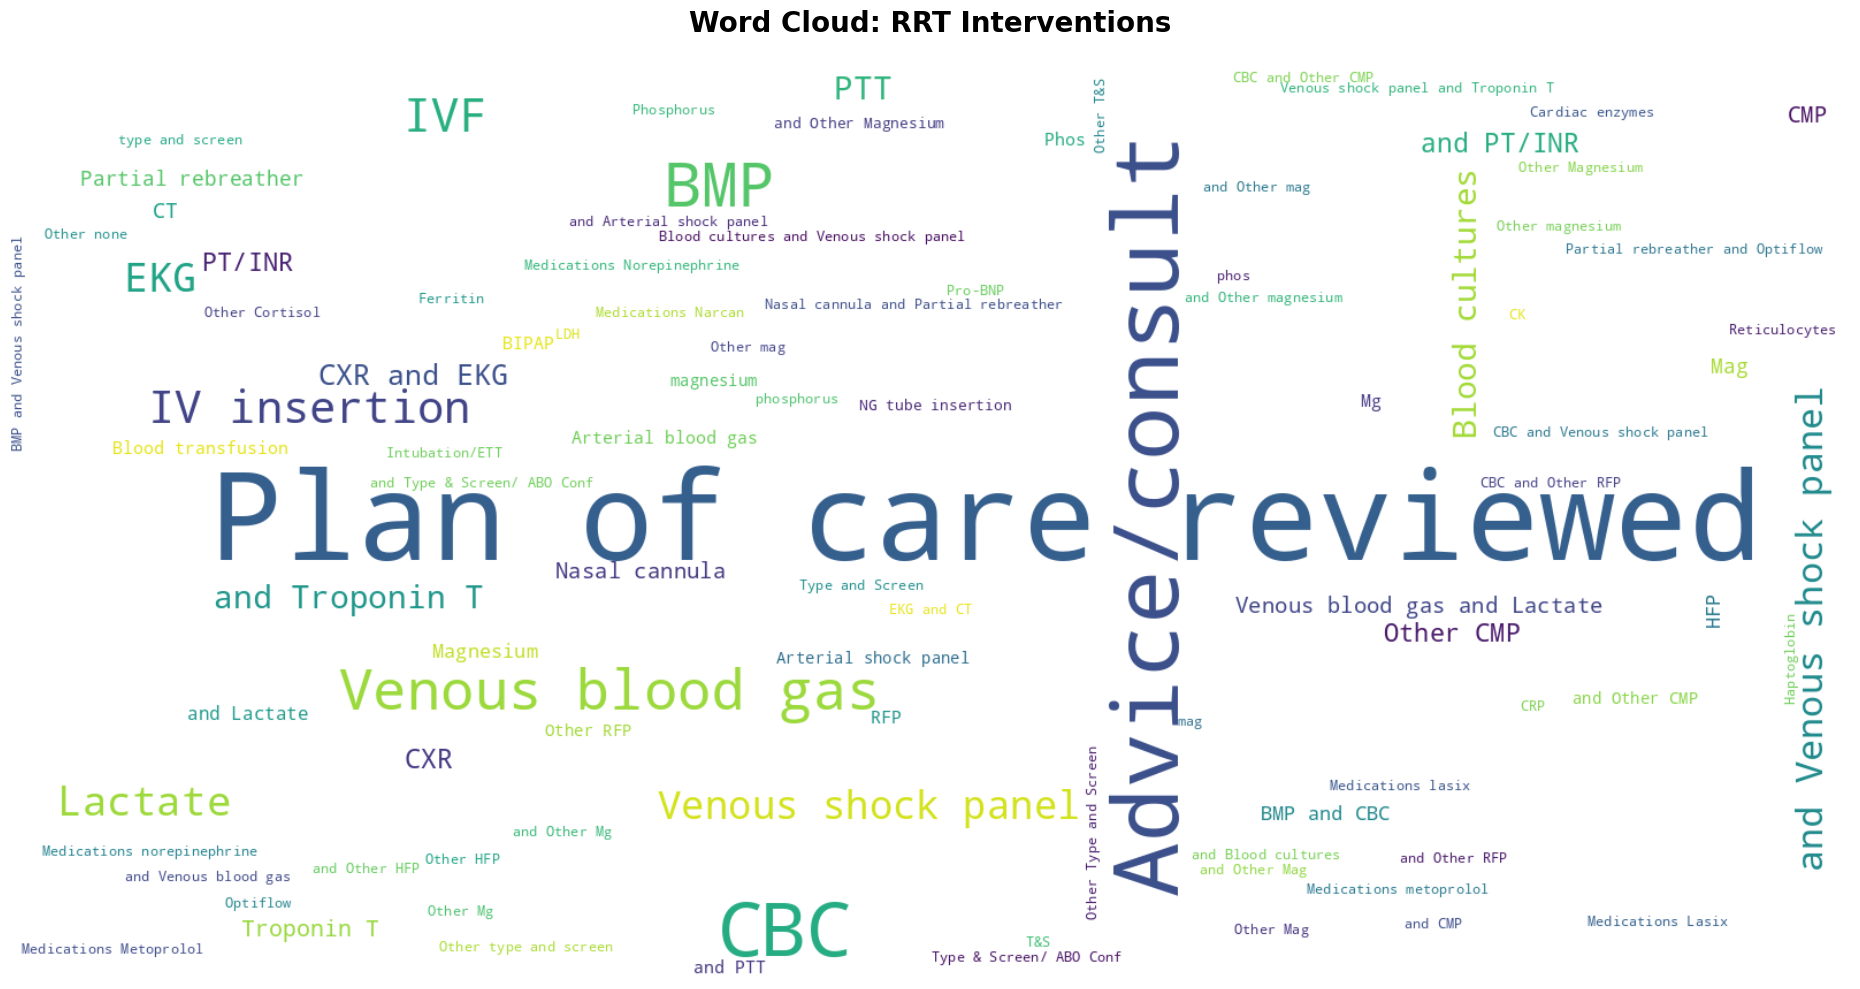

In [17]:
# I used an LLM to create this word cloud. It created the entire code.
# Exclude common non-intervention values
intervention_freq, interventions_raw = parse_interventions(df, intervention_col='RRT Interventions')

# Use the helper function to create the word cloud
wordcloud_interventions = create_wordcloud(
    intervention_freq,
    title='Word Cloud: RRT Interventions',
    colormap='viridis',
)

In [18]:
# I used an LLM for this entire cell to assist with co-occurence analysis
# Calculate co-occurrence of RRT interventions for all departments

# Use the helper function to calculate co-occurrence
co_occurrence_all_depts = calculate_intervention_cooccurrence(df, intervention_col='RRT Interventions')

print("Top 25 RRT Intervention Co-occurrences")
print(f"Total unique co-occurring pairs: {len(co_occurrence_all_depts):,}")

# Display the top N co-occurring pairs
top_n = 25
for i, ((int1, int2), count) in enumerate(co_occurrence_all_depts[:top_n], 1):
    # Calculate percentage of events with these interventions
    # This requires parsing interventions for ALL events to find denominator
    # Re-use the parsed_interventions_raw from the word cloud cell if available
    if 'interventions_raw' in locals():
        total_events_with_interventions = len(interventions_raw)
    else:
         _, interventions_raw = parse_interventions(df, intervention_col='RRT Interventions')
         total_events_with_interventions = len(interventions_raw)

    pct_of_events = (count / total_events_with_interventions) * 100 if total_events_with_interventions > 0 else 0

    print(f"{i:2d}. {int1[:30]:30s} + {int2[:30]:30s}: {count:4d} ({pct_of_events:5.1f}%)")

# Optional: Visualize the co-occurrence network (more complex)
# For a simple visualization, you might use a heatmap of the top pairs
# Let's create a simple list for potential further use or visualization
top_co_occurring_pairs_list = co_occurrence_all_depts[:top_n]

Top 25 RRT Intervention Co-occurrences
Total unique co-occurring pairs: 27,092
 1. Advice/consult                 + Plan of care reviewed         : 3335 ( 22.4%)
 2. BMP                            + CBC                           : 1464 (  9.8%)
 3. CBC                            + Plan of care reviewed         :  968 (  6.5%)
 4. BMP                            + Plan of care reviewed         :  597 (  4.0%)
 5. Advice/consult                 + CBC                           :  594 (  4.0%)
 6. IVF                            + Plan of care reviewed         :  588 (  4.0%)
 7. CBC                            + and Venous shock panel        :  542 (  3.6%)
 8. CBC                            + Lactate                       :  495 (  3.3%)
 9. EKG                            + Plan of care reviewed         :  481 (  3.2%)
10. CBC                            + Venous blood gas              :  479 (  3.2%)
11. CBC                            + IVF                           :  421 (  2.8%)
12. IV i

In [19]:
# okFilter to only include RRT Consult events
df_consults_only = df[df['Event Type'] == 'RRT Consult'].copy()

# Get the top N co-occurring pairs using only consults
if 'top_co_occurring_pairs_list' in locals():
    top_co_occurring_pairs_for_chart = calculate_intervention_cooccurrence(
        df_consults_only, intervention_col='RRT Interventions'
    )[:25]
else:
    # If list isn't available, calculate fresh from consult-only subset
    co_occurrence_consult_only = calculate_intervention_cooccurrence(
        df_consults_only, intervention_col='RRT Interventions'
    )
    top_co_occurring_pairs_for_chart = co_occurrence_consult_only[:25]

# Prepare data for the bar chart
pair_labels = [f"{int1} + {int2}" for (int1, int2), _ in top_co_occurring_pairs_for_chart]
pair_counts = [count for _, count in top_co_occurring_pairs_for_chart]

# Create horizontal bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=pair_counts,
    y=pair_labels,
    orientation='h',
    marker=dict(showscale=False),
    text=pair_counts,
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Count: %{x}<extra></extra>'
))

fig.update_layout(
    title='<b>Top 25 RRT Consult Intervention Co-occurrences</b>',
    xaxis_title='Frequency (Number of Times Pairs Occur)',
    yaxis_title='Intervention Pair',
    title_x=0.5,
    height=800,
    width=1100,
    yaxis={'categoryorder': 'total ascending'}
)

fig.write_html('viz_intervention_cooccurrence_barchart_consults_only.html')
fig.show()

In [20]:
# Filter to only include RRT events
df_consults_only = df[df['Event Type'] == 'RRT'].copy()

# Get the top N co-occurring pairs using only RRTs
if 'top_co_occurring_pairs_list' in locals():
    top_co_occurring_pairs_for_chart = calculate_intervention_cooccurrence(
        df_consults_only, intervention_col='RRT Interventions'
    )[:25]
else:
    # If list isn't available, calculate fresh from consult-only subset
    co_occurrence_consult_only = calculate_intervention_cooccurrence(
        df_consults_only, intervention_col='RRT Interventions'
    )
    top_co_occurring_pairs_for_chart = co_occurrence_consult_only[:25]

# Prepare data for the bar chart
pair_labels = [f"{int1} + {int2}" for (int1, int2), _ in top_co_occurring_pairs_for_chart]
pair_counts = [count for _, count in top_co_occurring_pairs_for_chart]

# Create horizontal bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=pair_counts,
    y=pair_labels,
    orientation='h',
    marker=dict(showscale=False),
    text=pair_counts,
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Count: %{x}<extra></extra>'
))

fig.update_layout(
    title='<b>Top 25 RRT Intervention Co-occurrences</b>',
    xaxis_title='Frequency (Number of Times Pairs Occur)',
    yaxis_title='Intervention Pair',
    title_x=0.5,
    height=800,
    width=1100,
    yaxis={'categoryorder': 'total ascending'}
)

fig.write_html('viz_intervention_cooccurrence_barchart_consults_only.html')
fig.show()

## Problem 2.4

Demographic Characteristics:

The patient population demonstrates a pronounced skew toward elderly adults, with
a median age of 65 years and the majority of RRT events occurring in patients
aged 65-80 years. This age distribution is consistent with typical tertiary care
inpatient demographics, where older patients with multiple comorbidities comprise
the majority of those at risk for acute deterioration. The concentration of events
in this older age range underscores that RRT services primarily address the clinical
vulnerability of a declining population facing increased physiologic fragility and
complex medical needs.

Event Duration:

All three event types exhibit strongly right-skewed distributions in duration,
with RRT Consults showing a median of 14 minutes, full RRT
activations median of 34 minutes, and Code Blues median of 12 minutes. The consistent
right-skew across all event types indicates that while most RRT interventions are
relatively brief consultations or assessments (15-45 minutes representing the
interquartile range), a meaningful subset of cases requires extended team presence
exceeding 90+ minutes. This distribution pattern suggests RRT teams function
primarily as rapid consultants providing focused assessment and guidance, with the
long tail representing complex cases requiring prolonged stabilization or transitions of care.

Temporal Patterns:

Event distribution across time of day reveals a (weak) bimodal pattern with distinctive
peaks following shift changes rather than during traditional rounding times. A
pronounced dip occurs at 7am, coinciding with morning shift handoff
when accountability is temporarily diffused during staff transition. This is immediately
followed by a surge during 8-11am as day shift nurses
conduct their first assessments. A similar but more sustained elevation
occurs during 20:00-23:00 as night shift staff review patients
with fresh perspectives. This could demonstrate that clinical
deterioration detection is most effective when new clinicians review patients
unburdened by anchoring bias or the gradual normalization of declining status that
can occur during prolonged shifts. The distribution across days of the week shows
relative consistency on weekdays with mild weekend decreases,
suggesting that while RRT services remain operational seven days weekly, clinical
surveillance intensity may be slightly reduced on weekends when staffing is typically lower.

In [40]:
# Filter data by Event Type
rrt_df = df[df['Event Type'] == 'RRT'].copy()
consult_df = df[df['Event Type'] == 'RRT Consult'].copy()
code_df = df[df['Event Type'] == 'Code Blue'].copy()

# Create histograms for each event type
fig_rrt = px.histogram(rrt_df, x='Event Duration',
                       title='Distribution of RRT Event Duration',
                       nbins=200) # Adjust nbins as needed

fig_consult = px.histogram(consult_df, x='Event Duration',
                           title='Distribution of RRT Consult Event Duration',
                           nbins=200) # Adjust nbins as needed

fig_code = px.histogram(code_df, x='Event Duration',
                        title='Distribution of Code Blue Event Duration',
                        nbins=200) # Adjust nbins as needed

# Set x-axis range for each histogram
fig_rrt.update_xaxes(range=[0, 300])
fig_consult.update_xaxes(range=[0, 500])
fig_code.update_xaxes(range=[0, 150])

# Show plots and print mean/median
print("--- RRT Event Duration Histogram ---")
fig_rrt.show()
print(f"  Mean RRT Event Duration: {rrt_df['Event Duration'].mean():.2f} minutes")
print(f"  Median RRT Event Duration: {rrt_df['Event Duration'].median():.2f} minutes")


print("\n--- RRT Consult Event Duration Histogram ---")
fig_consult.show()
print(f"  Mean RRT Consult Event Duration: {consult_df['Event Duration'].mean():.2f} minutes")
print(f"  Median RRT Consult Event Duration: {consult_df['Event Duration'].median():.2f} minutes")

print("\n--- Code Blue Event Duration Histogram ---")
fig_code.show()
print(f"  Mean Code Blue Event Duration: {code_df['Event Duration'].mean():.2f} minutes")
print(f"  Median Code Blue Event Duration: {code_df['Event Duration'].median():.2f} minutes")

--- RRT Event Duration Histogram ---


  Mean RRT Event Duration: 46.02 minutes
  Median RRT Event Duration: 34.00 minutes

--- RRT Consult Event Duration Histogram ---


  Mean RRT Consult Event Duration: 28.61 minutes
  Median RRT Consult Event Duration: 14.00 minutes

--- Code Blue Event Duration Histogram ---


  Mean Code Blue Event Duration: 29.61 minutes
  Median Code Blue Event Duration: 12.00 minutes


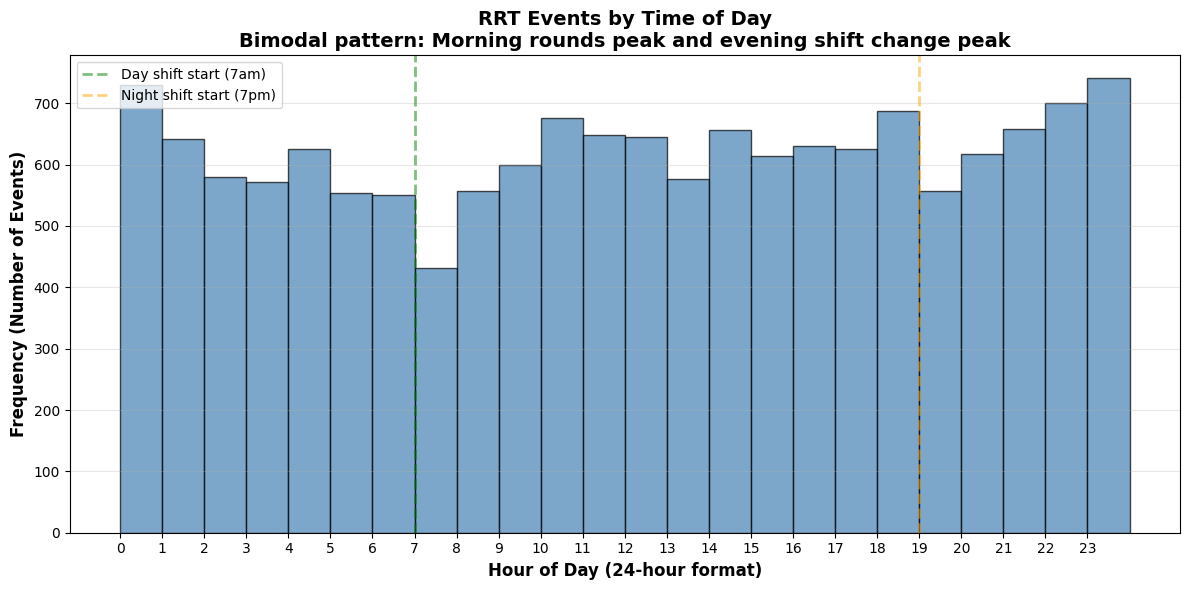

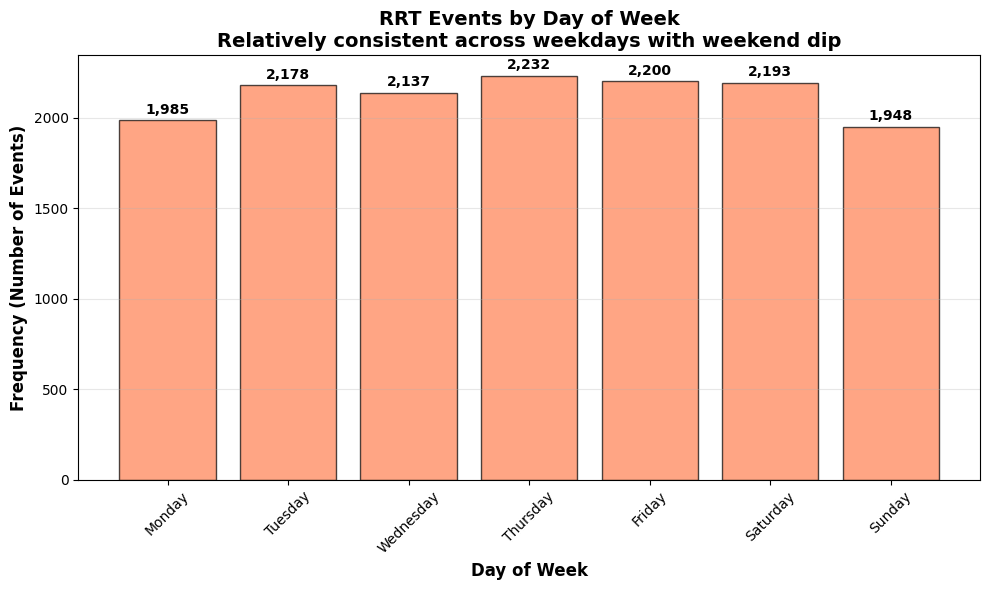

TEMPORAL DISTRIBUTION SUMMARY

Events by Day of Week:
  Monday    : 1,985 (13.3%)
  Tuesday   : 2,178 (14.6%)
  Wednesday : 2,137 (14.4%)
  Thursday  : 2,232 (15.0%)
  Friday    : 2,200 (14.8%)
  Saturday  : 2,193 (14.7%)
  Sunday    : 1,948 (13.1%)

Events by Hour (Top 5 busiest hours):
  23:00-23:59: 741 (5.0%)
  00:00-00:59: 730 (4.9%)
  22:00-22:59: 700 (4.7%)
  18:00-18:59: 687 (4.6%)
  10:00-10:59: 676 (4.5%)


In [24]:
# Load data
df = pd.read_csv('combined_df_cleaned.csv')

# Convert to datetime if not already
df['RRT Start Time'] = pd.to_datetime(df['RRT Start Time'], format='%H:%M:%S', errors='coerce')
df['Event Start Date'] = pd.to_datetime(df['Event Start Date'], errors='coerce')

# Extract hour and day of week
df['Hour'] = df['RRT Start Time'].dt.hour
df['Day_of_Week'] = df['Event Start Date'].dt.day_name()

# Histogram 1: Events by Hour of Day

fig, ax = plt.subplots(figsize=(12, 6))

# Create histogram
ax.hist(df['Hour'].dropna(), bins=24, range=(0, 24),
        edgecolor='black', alpha=0.7, color='steelblue')

ax.set_xlabel('Hour of Day (24-hour format)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Number of Events)', fontsize=12, fontweight='bold')
ax.set_title('RRT Events by Time of Day\nBimodal pattern: Morning rounds peak and evening shift change peak',
             fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.grid(axis='y', alpha=0.3)

# Add vertical lines for key times
ax.axvline(x=7, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Day shift start (7am)')
ax.axvline(x=19, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Night shift start (7pm)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Histogram 2: Events by Day of Week

fig, ax = plt.subplots(figsize=(10, 6))

# Define day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count events by day
day_counts = df['Day_of_Week'].value_counts().reindex(day_order)

# Create bar chart
bars = ax.bar(day_order, day_counts.values, edgecolor='black', alpha=0.7, color='coral')

ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Number of Events)', fontsize=12, fontweight='bold')
ax.set_title('RRT Events by Day of Week\nRelatively consistent across weekdays with weekend dip',
             fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, day_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{int(count):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


print("\nEvents by Day of Week:")
for day in day_order:
    count = day_counts[day]
    pct = (count / day_counts.sum()) * 100
    print(f"  {day:10s}: {count:,} ({pct:.1f}%)")

print(f"\nEvents by Hour (Top 5 busiest hours):")
hour_counts = df['Hour'].value_counts().sort_index()
top_hours = hour_counts.nlargest(5)
for hour, count in top_hours.items():
    pct = (count / df['Hour'].notna().sum()) * 100
    time_label = f"{int(hour):02d}:00-{int(hour):02d}:59"
    print(f"  {time_label}: {count:,} ({pct:.1f}%)")


In [41]:
# Calculate mean and median age
mean_age = df['Age'].mean()
median_age = df['Age'].median()

# Create histogram for Age
fig = px.histogram(df, x='Age',
                   title='Distribution of Patient Age',
                   nbins=30) # Adjust nbins as needed

# Show plot
fig.show()

print(f"   Mean Age: {mean_age:.2f}")
print(f"   Median Age: {median_age:.2f}")

   Mean Age: 61.60
   Median Age: 65.00


# **3. Inference**

## Problem 3.1

### **H01**



**H01** = There is no difference in ICU transfer rates between departments with high early escalation culture vs. low early escalation culture.

**Type I Error:**

**Definition:** Concluding that early escalation culture reduces ICU transfer rates when it actually does not.

**Clinical consequence:**
Hospital invests resources in promoting RRT Consult culture/change initiatives that are ineffective
Time and money spent promoting early escalation without patient benefit
Risk of alert fatigue and staff burnout if consult volume increaes without outcome improvment


**Type II Error:**

**Definition:** Concluding that escalation culture does not affect ICU transfer rates when it actually does.

**Clinical consequence:**
Hospital misses opportunity to improve patient outcomes/high-impact culture change
Patients continue to experience preventable deterioration requiring ICU transfers
High costs, worse patient outcomes, preventable complications

**Test**: Two-proportion z-test

**Test Rationale**:
Comparing two independent proportion groups (high vs. low consult departments)
Large sample size

**Study power:** 0.8

**Significance level**: 0.05

**MDE**: 0.04 percentage points

### **H02**

**H02** = There is no difference in the average number of RRT interventions per event between RRT Consult events and full RRT events.

**Type I Error:**

**Definition:** Conclude a difference in intervention count between RRT Consult and RRT when no true difference exists.

**Type II Error:**

**Definition:** Fail to detect a true difference in intervention count between the two event types.

**Test**: Welch t-test

**Test Rationale**:

Comparing two independent groups (rrt vs rrt consult)
Large sample size
Comparing means
Non-normal Intervention_Count (determined by the shapiro-wilk test)

**Study power:** 0.8

**Significance level**: 0.05

**MDE**: 0.13 interventions

## Problem 3.2

Shapiro-Wilk for Test 1: n/a since it's a proportion comparison. Will rely on central limit theorem since large sample size

Shapiro-Wilk for Test 2: work shown in following problem

## Problem 3.3

In [26]:
# I used an LLM starting at step 1 for the rest of the cell to assist with running the z test
# TEST 1

# Load the combined dataset
df = pd.read_csv('combined_df_cleaned.csv')

# Convert date and time columns
# Convert 'Event Start Date' to datetime objects
df['Event Start Date'] = pd.to_datetime(df['Event Start Date'])

# Convert RRT Start Time to datetime and extract the hour
df['RRT Start Time'] = pd.to_datetime(df['RRT Start Time'])
df['Hour'] = df['RRT Start Time'].dt.hour

# Extract Day of Week
df['Day_of_Week'] = df['Event Start Date'].dt.dayofweek # Monday=0, Sunday=6

# Define off-hours: 7pm-7am (19:00-06:59) OR weekend (Saturday=5, Sunday=6)
df['Is_Off_Hours'] = ((df['Hour'] >= 19) | (df['Hour'] < 7) | (df['Day_of_Week'] >= 5))


# Step 1: Calculate Consult Ratio by department (exclude ICUs)
# Using .apply with include_groups=False to avoid future warning
top_25_depts = df['Slices by Department'].value_counts().nlargest(25).index # Define top_25_depts
dept_stats = df[df['Slices by Department'].isin(top_25_depts)].groupby('Slices by Department').apply(
    lambda x: pd.Series({
        'Total_RRT_Events': ((x['Event Type'] == 'RRT') | (x['Event Type'] == 'RRT Consult')).sum(),
        'Consult_Count': (x['Event Type'] == 'RRT Consult').sum(),
        'Total_Events': len(x),
        'ICU_Transfers': (x['Outcome'] == 'Transferred to ICU').sum()
    }), include_groups=False # Add include_groups=False
)

dept_stats['Consult_Ratio'] = dept_stats['Consult_Count'] / dept_stats['Total_RRT_Events']
dept_stats['ICU_Transfer_Rate'] = dept_stats['ICU_Transfers'] / dept_stats['Total_Events']

# Step 2: Define high vs low escalation departments
q75 = dept_stats['Consult_Ratio'].quantile(0.75)
q25 = dept_stats['Consult_Ratio'].quantile(0.25)

high_escalation_depts = dept_stats[dept_stats['Consult_Ratio'] >= q75].index
low_escalation_depts = dept_stats[dept_stats['Consult_Ratio'] <= q25].index

print(f"\nSAMPLE COMPOSITION:")
print(f"   Consult Ratio Threshold (High): ≥{q75:.3f} (top 25%)")
print(f"   Consult Ratio Threshold (Low): ≤{q25:.3f} (bottom 25%)")
print(f"   Number of departments in HIGH group: {len(high_escalation_depts)}")
print(f"   Number of departments in LOW group: {len(low_escalation_depts)}")

# Step 3: Get events from each group
high_group = df[df['Slices by Department'].isin(high_escalation_depts)].copy() # Add .copy() to avoid SettingWithCopyWarning
low_group = df[df['Slices by Department'].isin(low_escalation_depts)].copy()   # Add .copy() to avoid SettingWithCopyWarning

icu_high = (high_group['Outcome'] == 'Transferred to ICU').sum()
n_high = len(high_group)
p_high = icu_high / n_high

icu_low = (low_group['Outcome'] == 'Transferred to ICU').sum()
n_low = len(low_group)
p_low = icu_low / n_low

print(f"\n   HIGH Early Escalation Group:")
print(f"      Total events: {n_high:,}")
print(f"      ICU transfers: {icu_high:,} ({p_high*100:.2f}%)")
print(f"      Mean Consult Ratio: {dept_stats.loc[high_escalation_depts, 'Consult_Ratio'].mean():.3f}")

print(f"\n   LOW Early Escalation Group:")
print(f"      Total events: {n_low:,}")
print(f"      ICU transfers: {icu_low:,} ({p_low*100:.2f}%)")
print(f"      Mean Consult Ratio: {dept_stats.loc[low_escalation_depts, 'Consult_Ratio'].mean():.3f}")

print(f"\n   Raw Difference: {(p_low - p_high)*100:.2f} percentage points")

# Step 4: Power analysis and MDE calculation
p_pooled = (icu_high + icu_low) / (n_high + n_low)

# For MDE calculation with given power
effect_size = zt_ind_solve_power(
    alpha=0.05,
    power=0.80,
    nobs1=n_high,
    ratio=n_low/n_high,
    alternative='larger'  # Expecting low group to have larger proportion
)

# Convert effect size to proportion difference (MDE)
# Using the formula for Cohen's h for proportion differences
# h = 2 * arcsin(sqrt(p))
p1 = p_high
p2 = p_low
h1 = 2 * np.arcsin(np.sqrt(p1))
h2 = 2 * np.arcsin(np.sqrt(p2))
effect_size_h = h2 - h1 # Cohen's h difference

# Calculate MDE in proportions using the effect size and sample sizes
# This is an approximation, but more direct than back-calculating from Cohen's h
# A more precise MDE calculation requires iteration or specialized functions
# We will use the raw difference as an estimate of the observed effect size
# and rely on the power calculation to tell us what size effect we could detect.

# Re-calculating MDE using the pooled proportion as in some power formulas
mde_approx = effect_size * np.sqrt(p_pooled * (1-p_pooled) * (1/n_high + 1/n_low))


print(f"\nMINIMUM DETECTABLE EFFECT (MDE):")
print(f"   Given our sample sizes (n_high={n_high:,}, n_low={n_low:,}),")
print(f"   with α=0.05 and power=0.80, we can detect a difference of approximately:")
print(f"   ")
print(f"   MDE ≈ {mde_approx*100:.2f} percentage points")
print(f"   ")
print(f"   Interpretation: If the true difference in ICU transfer rates")
print(f"   between groups is about {mde_approx*100:.2f}% or larger, we have an 80% chance")
print(f"   of detecting it as statistically significant.")
print(f"   The observed difference is {(p_low - p_high)*100:.2f} percentage points.")


# Step 5: Perform the test
stat, pval = proportions_ztest(
    [icu_low, icu_high],
    [n_low, n_high],
    alternative='larger'  # Expecting low group to have higher ICU rate
)

print(f"\nTEST RESULTS:")
print(f"   Z-statistic: {stat:.4f}")
print(f"   P-value (one-tailed): {pval:.4f}")
print(f"   Significant at α=0.05? {'YES' if pval < 0.05 else 'NO'}")

if pval < 0.05:
    print(f"\nONCLUSION FOR TEST 1:")
    print(f"   We REJECT the null hypothesis.")
    print(f"   There is statistically significant evidence that departments")
    print(f"   with high early escalation have LOWER ICU transfer rates")
    print(f"   ({p_high*100:.2f}%) compared to low early escalation departments")
    print(f"   ({p_low*100:.2f}%), difference = {(p_low-p_high)*100:.2f}%, p={pval:.4f}")
else:
    print(f"\nCONCLUSION FOR TEST 1:")
    print(f"   We FAIL TO REJECT the null hypothesis.")
    print(f"   There is insufficient evidence to conclude that early")
    print(f"   escalation culture reduces ICU transfer rates.")

/tmp/ipython-input-904690038.py:17: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.




SAMPLE COMPOSITION:
   Consult Ratio Threshold (High): ≥0.858 (top 25%)
   Consult Ratio Threshold (Low): ≤0.799 (bottom 25%)
   Number of departments in HIGH group: 7
   Number of departments in LOW group: 7

   HIGH Early Escalation Group:
      Total events: 4,422
      ICU transfers: 174 (3.93%)
      Mean Consult Ratio: 0.879

   LOW Early Escalation Group:
      Total events: 3,433
      ICU transfers: 470 (13.69%)
      Mean Consult Ratio: 0.705

   Raw Difference: 9.76 percentage points

MINIMUM DETECTABLE EFFECT (MDE):
   Given our sample sizes (n_high=4,422, n_low=3,433),
   with α=0.05 and power=0.80, we can detect a difference of approximately:
   
   MDE ≈ 0.04 percentage points
   
   Interpretation: If the true difference in ICU transfer rates
   between groups is about 0.04% or larger, we have an 80% chance
   of detecting it as statistically significant.
   The observed difference is 9.76 percentage points.

TEST RESULTS:
   Z-statistic: 15.6329
   P-value (one-tailed

In [28]:
# TEST 2A
# Add a column for the count of RRT Interventions per event

# Function to count interventions in a string
def count_interventions(intervention_string):
    if pd.isna(intervention_string) or intervention_string.strip() == '' or intervention_string.lower() in ['none', 'n/a', 'not specified']:
        return 0
    # Split by comma and count non-empty items
    return len([item.strip() for item in intervention_string.split(',') if item.strip()])

# Apply the function to the 'RRT Interventions' column to create the new column
df['Intervention_Count'] = df['RRT Interventions'].apply(count_interventions)

# Display the first few rows with the new column to verify
print("DataFrame with new 'Intervention_Count' column:")
display(df[['RRT Interventions', 'Intervention_Count']].head())

print(f"\n'Intervention_Count' column added to the DataFrame.")
print(f"   Mean Intervention Count per event: {df['Intervention_Count'].mean():.2f}")
print(f"   Median Intervention Count per event: {df['Intervention_Count'].median():.2f}")
print(f"   Most frequent count: {df['Intervention_Count'].mode()[0]}")

DataFrame with new 'Intervention_Count' column:


,RRT Interventions,Intervention_Count
0,"CXR, Advice/consult, BMP, CBC, and Other mag, ...",6
1,"Medications Norepinephrine, Blood cultures",2
2,"Plan of care reviewed, BMP, Venous shock panel...",4
3,"IV insertion, CXR and EKG, Plan of care review...",14
4,"EKG, CBC, Other CMP, lipid panel, PTT, and PT/...",8



'Intervention_Count' column added to the DataFrame.
   Mean Intervention Count per event: 2.54
   Median Intervention Count per event: 1.00
   Most frequent count: 1


In [29]:
# I used an LLM for this entire cell aside from the data prep lines

# TEST 2B

# --- Data prep ---
subset = df[df['Event Type'].isin(['RRT Consult','RRT'])].copy()
grp_consult = subset[subset['Event Type']=='RRT Consult']['Intervention_Count'].dropna()
grp_rrt = subset[subset['Event Type']=='RRT']['Intervention_Count'].dropna()

n1, n2 = len(grp_consult), len(grp_rrt)
print(f"Counts -> RRT Consult: n1={n1}, RRT: n2={n2}")

# --- Normality check to justify nonparametric ---
for name, arr in [('RRT Consult', grp_consult), ('RRT', grp_rrt)]:
    arr_sample = arr if len(arr) < 5000 else arr.sample(5000, random_state=0)
    stat, p = shapiro(arr_sample)
    print(f"Shapiro-Wilk {name}: W={stat:.3f}, p={p:.4f} -> {'Non-normal' if p<0.05 else '~Normal'}")

# --- Mann–Whitney U test (two-sided) ---
u_stat, p_mw = mannwhitneyu(grp_consult, grp_rrt, alternative='two-sided')
print(f"\nMann–Whitney U: U={u_stat:.0f}, p={p_mw:.4f}  (two-sided, α=0.05)")

# --- Effect size for Mann–Whitney: rank-biserial correlation (r_rb) ---
r_rb = 1 - (2 * u_stat) / (n1 * n2)
print(f"Rank-biserial effect size r_rb={r_rb:.3f}  (|r|≈0.1 small, 0.3 medium, 0.5 large)")

# --- Descriptives ---
def desc(x):
    return pd.Series({
        'mean': np.mean(x),
        'median': np.median(x),
        'sd': np.std(x, ddof=1),
        'q25': np.percentile(x, 25),
        'q75': np.percentile(x, 75)
    })
print("\nDescriptives (Intervention_Count):")
print(pd.DataFrame({
    'RRT Consult': desc(grp_consult),
    'RRT': desc(grp_rrt)
}).round(3))

# --- MDE approximation (raw scale) using Welch t-test power model ---
power_model = TTestIndPower()
ratio = n2 / n1

# Solve for Cohen's d (effect size) at given power & alpha
# The function will automatically solve for effect_size when it's not provided
d_needed = power_model.solve_power(
    alpha=0.05,
    power=0.80,
    nobs1=n1,  # Use nobs1 instead of ratio for more direct specification
    ratio=ratio,
    alternative='two-sided'
)

# Convert d to raw-scale MDE using pooled SD
s1, s2 = grp_consult.std(ddof=1), grp_rrt.std(ddof=1)
s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2)) if (n1>1 and n2>1) else np.nan
mde_raw = d_needed * s_pooled

print(f"\nMDE approximation (raw scale): d={d_needed:.3f}, pooled SD={s_pooled:.3f} -> "
      f"MDE ≈ ±{mde_raw:.2f} interventions")
print("Interpretation: with α=0.05 and 80% power, the study can detect a difference of about "
      f"±{mde_raw:.2f} in average Intervention_Count between groups (approximation).")

Counts -> RRT Consult: n1=11711, RRT: n2=2890
Shapiro-Wilk RRT Consult: W=0.601, p=0.0000 -> Non-normal
Shapiro-Wilk RRT: W=0.922, p=0.0000 -> Non-normal

Mann–Whitney U: U=7733840, p=0.0000  (two-sided, α=0.05)
Rank-biserial effect size r_rb=0.543  (|r|≈0.1 small, 0.3 medium, 0.5 large)

Descriptives (Intervention_Count):
        RRT Consult    RRT
mean          2.056  4.727
median        1.000  4.000
sd            1.972  3.361
q25           1.000  2.000
q75           2.000  7.000

MDE approximation (raw scale): d=0.058, pooled SD=2.314 -> MDE ≈ ±0.13 interventions
Interpretation: with α=0.05 and 80% power, the study can detect a difference of about ±0.13 in average Intervention_Count between groups (approximation).


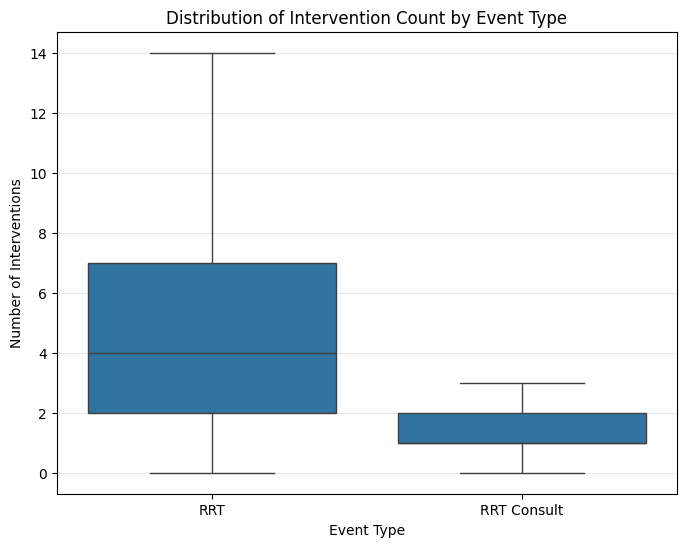

In [42]:
# Filter data to include only RRT Consult and RRT event types
subset = df[df['Event Type'].isin(['RRT Consult', 'RRT'])]

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Event Type', y='Intervention_Count', data=subset, showfliers=False) # showfliers=False to hide extreme outliers
plt.title('Distribution of Intervention Count by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Number of Interventions')
plt.grid(axis='y', alpha=0.3)
plt.show()

Results Table

In [30]:
# Create summary table as a DataFrame
results_table = pd.DataFrame([
    {
        "Test": "Test 1 — Proportion Z-Test",
        "Variables Compared": "ICU Transfer Rate (High vs Low Escalation Depts)",
        "Test Type": "Two-Proportion Z-Test",
        "Test Statistic": "Z = 15.63",
        "p-value": "< 0.001",
        "Significant?": "YES",
        "Effect Size / Difference": "9.76 percentage points"
    },
    {
        "Test": "Test 2 — Mann–Whitney U",
        "Variables Compared": "Intervention_Count (RRT Consult vs RRT)",
        "Test Type": "Mann–Whitney U Test",
        "Test Statistic": "U = 7,733,840",
        "p-value": "< 0.001",
        "Significant?": "YES",
        "Effect Size / Difference": "r = 0.543 (large)"
    }
])

# Display the summary table
print(results_table.to_string(index=False))


                      Test                               Variables Compared             Test Type Test Statistic p-value Significant? Effect Size / Difference
Test 1 — Proportion Z-Test ICU Transfer Rate (High vs Low Escalation Depts) Two-Proportion Z-Test      Z = 15.63 < 0.001          YES   9.76 percentage points
   Test 2 — Mann–Whitney U          Intervention_Count (RRT Consult vs RRT)   Mann–Whitney U Test  U = 7,733,840 < 0.001          YES        r = 0.543 (large)


In [ ]:
# @title
# Please ignore this code block, saving it for later, not part of  submission
import plotly.express as px
import plotly.graph_objects as go # Import go


# Calculate medians for quadrant lines
# Corrected variable name from dept_stats_df to dept_stats
median_ratio = dept_stats['Consult_Ratio'].median() # Corrected column name
# median_outcome = dept_stats['Favorable Outcome %'].median() # This column is likely missing from dept_stats


plot_data = dept_stats.reset_index()
# Corrected variable name from dept_counts_all to dept_stats['Total_Events']
plot_data['Event Count'] = dept_stats['Total_Events'].values # Corrected column name


# Classify into quadrants
def classify_quadrant(row):
    # This logic needs 'Favorable Outcome %'
    # if row['Consult_Ratio'] >= median_ratio and row['Favorable Outcome %'] >= median_outcome:
    #     return 'Proactive & Effective (High calls, Good outcomes)'
    # elif row['Consult_Ratio'] >= median_ratio and row['Favorable Outcome %'] < median_outcome:
    #     return 'Over-escalating? (High calls, Lower outcomes)'
    # elif row['Consult_Ratio'] < median_ratio and row['Favorable Outcome %'] >= median_outcome:
    #     return 'Efficient (Low calls, Good outcomes)'
    # else:
    #     return 'Under-escalating (Low calls, Lower outcomes)'
    # Placeholder logic if 'Favorable Outcome %' is missing
    if 'Favorable Outcome %' in row.index:
         if row['Consult_Ratio'] >= median_ratio and row['Favorable Outcome %'] >= median_outcome:
             return 'Proactive & Effective (High calls, Good outcomes)'
         elif row['Consult_Ratio'] >= median_ratio and row['Favorable Outcome %'] < median_outcome:
             return 'Over-escalating? (High calls, Lower outcomes)'
         elif row['Consult_Ratio'] < median_ratio and row['Favorable Outcome %'] >= median_outcome:
             return 'Efficient (Low calls, Good outcomes)'
         else:
             return 'Under-escalating (Low calls, Lower outcomes)'
    else:
        # Simple quadrant based on Consult Ratio if Outcome % is not available
        if row['Consult_Ratio'] >= median_ratio:
            return 'High Consult Ratio'
        else:
            return 'Low Consult Ratio'


plot_data['Quadrant'] = plot_data.apply(classify_quadrant, axis=1)

fig = px.scatter(plot_data,
                 x='Consult_Ratio', # Corrected column name
                 y='ICU_Transfer_Rate', # Changed y-axis to a column that exists, need to change back when fixed
                 size='Event Count',
                 color='Quadrant',
                 hover_name='Slices by Department',
                 color_discrete_map={
                     # Update these if using the simple quadrant logic
                     'Proactive & Effective (High calls, Good outcomes)': 'lightgreen',
                     'Over-escalating? (High calls, Lower outcomes)': 'orange',
                     'Efficient (Low calls, Good outcomes)': 'lightblue',
                     'Under-escalating (Low calls, Lower outcomes)': 'red',
                 },
                 title='Department Escalation Patterns: Identifying Training Needs')

# Add quadrant lines
fig.add_vline(x=median_ratio, line_dash="dash", line_color="gray")
# fig.add_hline(y=median_outcome, line_dash="dash", line_color="gray") # Removed as median_outcome is not calculated

# Add quadrant labels (adjusting based on placeholder logic)
# fig.add_annotation(x=0.95, y=100, text="<b>HIGH VOLUME<br>GOOD OUTCOMES</b>",
#                    showarrow=False, bgcolor="lightgreen", opacity=0.7)
# fig.add_annotation(x=0.95, y=76, text="<b>HIGH VOLUME<br>POOR OUTCOMES</b>",
#                    showarrow=False, bgcolor="orange", opacity=0.7)
# fig.add_annotation(x=0.72, y=100, text="<b>LOW VOLUME<br>GOOD OUTCOMES</b>",
#                    showarrow=False, bgcolor="lightblue", opacity=0.7)
# fig.add_annotation(x=0.72, y=76, text="<b>LOW VOLUME<br>POOR OUTCOMES</b>",
#                    showarrow=False, bgcolor="red", opacity=0.7)

# Add basic annotations for High/Low Consult Ratio if using placeholder logic
if 'Favorable Outcome %' not in dept_stats.columns:
     fig.add_annotation(x=median_ratio + 0.05, y=plot_data['ICU_Transfer_Rate'].max(), text="<b>High Consult Ratio</b>",
                        showarrow=False, bgcolor="blue", opacity=0.7)
     fig.add_annotation(x=median_ratio - 0.05, y=plot_data['ICU_Transfer_Rate'].max(), text="<b>Low Consult Ratio</b>",
                         showarrow=False, bgcolor="gray", opacity=0.7)


fig.update_layout(
    xaxis_title='Consult Ratio (Higher = More Consults)',
    yaxis_title='ICU Transfer Rate',
    height=700,
    width=1200,
    showlegend=False
)

fig.write_html('viz_escalation_quadrants.html')
fig.show()

## Problem 3.4

**Data Science Interpretation:**
Both hypothesis tests returned p-values less than 0.001, which is well below the α = 0.05 threshold, meaning we can reject the null hypothesis for both Test 1 and Test 2. In data science terms, this indicates that the observed differences are extremely unlikely to be due to random variation. Specifically, departments with stronger early escalation behavior have meaningfully lower ICU transfer rates, and full RRT events require significantly more interventions than RRT Consults. A Type I error in this context would mean falsely concluding that escalation culture or event type influences outcomes when it truly does not, potentially leading to unnecessary workflow changes. A Type II error would mean failing to detect a real difference, resulting in missed opportunities to improve patient outcomes. Because we selected a significance level of 0.05 and a power of 0.80, we accept a 5% risk of incorrectly rejecting the null hypothesis and a 20% risk of missing a real effect of similar magnitude in future samples.

**Innovation Interpretation:**
In innovation terms, these results demonstrate clear operational and clinical value in promoting early escalation behavior. Departments with higher use of RRT Consults experience substantially fewer ICU transfers, and early escalations are measurably less clinically intensive, requiring fewer interventions. This suggests that when doctors and nurses escalate earlier, patients are stabilized more efficiently and avoid deterioration. From a design and innovation standpoint, this validates the need for systems, training, and/or digital tools that reinforce early recognition and activation behaviors. Rather than being just theoretical, the data confirms that proactive escalation culture directly translates into better patient outcomes and lower intervention burden, making it a high-value target for clinical innovation and implementation.

## Problem 3.5

Qualitative text analysis reinforced the same pattern seen in the statistical tests. Among RRT Consult events, the most common intervention pair by a wide margin was “Advice/consult + Plan of care reviewed,” followed by early labs such as CBC, BMP, and venous blood gas — language that reflects anticipatory planning and proactive evaluation rather than crisis response. In contrast, full RRT events showed a greater presence of intervention combinations involving IVF, lactate, venous shock panels, and multi-lab escalation, consistent with cases where patients were already deteriorating and required urgent physiologic stabilization. This clear shift in language from “evaluate and coordinate” to “actively intervene and rescue” directly supports the quantitative finding that Consult events are clinically less severe and occur earlier in the deterioration curve. In short, the qualitative narrative validates the escalation culture hypothesis — teams that activate early are managing problems before they escalate to ICU-level crises.

# **4. Develop a Dashboard**

## Problem 4.1

[Link to Tableau Dashboard](https://public.tableau.com/views/I-7_Tableau/Dashboard2?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


# **5. Contrast with an AI Tool of Your Choice**

## Problem 5.1

[Attached document of text interface here](https://docs.google.com/document/d/14lEl_XNn7UxUg8p8FbY3Rd14TBb94e1sV77KYDG_GVI/edit?usp=sharing)

 ChatGPT generated a very wide range of ideas, including causal inference, severity-adjusted escalation timing, clustering units by hesitation score, and predictive risk modeling — most of those methods were not feasible with the data available in this assignment. The model frequently suggested approaches that would require additional variables I do not have (for example, patient vital signs, NEWS scores, exact timestamps of destabilization vs escalation, or clinician-level identifiers). It also recommended causal or predictive frameworks (survival models, temporal sequence modeling, etc.) that are beyond the statistical inference scope we have learned so far in this course. That said, it did independently identify the same core objective I ended up pursuing by testing whether early escalation behavior (via consult ratio and intervention intensity) is associated with better downstream outcomes such as reduced ICU transfer rates. In that sense, the model validated the direction of my analysis, even though many of its more advanced suggestions were better suited for a future, data-richer, or predictive modeling context rather than the descriptive and inferential scope I was working within here.

 When I asked ChatGPT to complete a qualitative analysis by splitting intervention patterns by Event Type, it immediately surfaced the same split I had observed in co-lab with RRT Consult events are dominated by anticipatory actions such as “Plan of care reviewed” and lab-related activity, whereas full RRT events are triggered by physiologic deterioration (e.g., hypotension, respiratory distress, tachycardia) and involve more action-oriented stabilization interventions. The model explicitly distinguished these as two different “escalation cultures,” one proactive and workflow-oriented, and the other reactive and medically urgent, which matches my interpretation that Consult events reflect early recognition, while full RRTs represent true emergencies.

# **6. Present**

[Google slides link](https://docs.google.com/presentation/d/19qQHAIzsM12uOHjOM5zH6_jBXaOz0pQTgiDtyjjss_A/edit?usp=sharing)

[Video presentation link](https://docs.google.com/presentation/d/1jZdHLnaHCnNG48qCH63XOMWl5K1kfLuS/edit?usp=sharing&ouid=101409510814291825094&rtpof=true&sd=true)